## TD Learning - Grid World Example

This time we will use an environment from the [<tt>GridWorlds.jl</tt>](https://github.com/JuliaReinforcementLearning/GridWorlds.jl) package:

In [1]:
using ReinforcementLearningBase, GridWorlds
using PyPlot

world = GridWorlds.GridRoomsDirectedModule.GridRoomsDirected();
env = GridWorlds.RLBaseEnv(world)

# RLBaseEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |   InternalState{Any}() |
| DefaultStateStyle |   InternalState{Any}() |

## Is Environment Terminated?

No

## State Space

`nothing`

## Action Space

`Base.OneTo(4)`

## Current State

```
([0 0 0 0 0 0 0 0 0; 1 1 1 1 1 1 1 1 1; 0 0 0 0 0 0 0 0 0;;; 0 0 0 0 0 0 0 0 0; 1 0 0 0 1 0 0 0 1; 0 0 0 0 0 0 0 0 0;;; 0 0 0 0 0 0 0 0 0; 1 0 0 0 0 0 0 0 1; 0 0 0 1 0 0 0 0 0;;; 0 0 0 0 0 1 0 0 0; 1 0 0 0 1 0 0 0 1; 0 0 0 0 0 0 0 0 0;;; 0 0 0 0 0 0 0 0 0; 1 1 0 1 1 1 0 1 1; 0 0 0 0 0 0 0 0 0;;; 0 0 0 0 0 0 0 0 0; 1 0 0 0 1 0 0 0 1; 0 0 0 0 0 0 0 0 0;;; 0 0 0 0 0 0 0 0 0; 1 0 0 0 0 0 0 0 1; 0 0 0 0 0 0 0 0 0;;; 0 0 0 0 0 0 0 0 0; 1 0 0 0 1 0 0 0 1; 0 0 0 0 0 0 0 0 0;;; 0 0 0 0 0 0 0 0 0; 1 1 1 1 1 1 1 1 1; 0 0 0 0 0 0 0 0 0], 1)
```


Now, we will define agent:

In [2]:
mutable struct Agent
    env::AbstractEnv
    algo::Symbol
    ϵ::Float64 #współczynnik eksploracji
    ϵ_decay::Float64
    ϵ_min::Float64
    β::Float64 #dyskonto
    α::Float64 #stopa uczenia się
    Q::Dict
    score::Int #wynik - ile razy agent dotarl do mety
    steps_per_episode::Vector{Float64} #ile trwal przecietny epizod
end

function Agent(env, algo; ϵ = 1.0, ϵ_decay = 0.9975, ϵ_min = 0.005,
        β = 0.99, α = 0.1) 
    if algo != :SARSA && algo != :Qlearning
        @error "unknown algorithm"
    end
    Agent(env, algo,
        ϵ, ϵ_decay, ϵ_min, β, α, 
        Dict(), 0, [0.0,])
end

Agent

And learning functions: one for SARSA algorithm and one for Q-Learning:

In [3]:
#Q learning
function learn!(agent, S, A, r, S′)
    if !haskey(agent.Q, S)
        agent.Q[S] = zeros(length(action_space(agent.env)))
        agent.Q[S][A] = r
    else
        Q_S′ = 0.0
        haskey(agent.Q, S′) && ( Q_S′ += maximum(agent.Q[S′]))
        agent.Q[S][A] += agent.α * (r + agent.β*Q_S′ - agent.Q[S][A])
    end
end

#SARSA
function learn!(agent, S, A, r, S′,A′)
    if !haskey(agent.Q, S)
        agent.Q[S] = zeros(length(action_space(agent.env)))
        agent.Q[S][A] = r
    else
        Q_S′ = 0.0
        haskey(agent.Q, S′) && (Q_S′ += agent.Q[S′][A′])
        agent.Q[S][A] += agent.α * (r + agent.β*Q_S′ - agent.Q[S][A])
    end
end

learn! (generic function with 2 methods)

Finally, the main function:

In [4]:
function run_learning!(agent, steps; burning = true, 
        animated = nothing) 
    step = 1.0
    steps_per_episode = 1.0
    episode = 1.0
    if !isnothing(animated)
        global str = ""
        global str = str * "FRAME_START_DELIMITER"
        global str = str * "step: $(step)\n"
        global str = str * "episode: $(episode)\n"
        global str = str * repr(MIME"text/plain"(), env)
        global str = str * "\ntotal_reward: 0"
    end
    while step <= steps
        S = deepcopy(state(agent.env))
        if (burning && step < 0.1*steps) || rand() < agent.ϵ || !haskey(agent.Q, state(agent.env))
            A = rand(1:length(action_space(agent.env)))
        else 
            A = argmax(agent.Q[state(agent.env)])
        end
        agent.env(action_space(agent.env)[A])
        r = reward(agent.env)
        S′ = deepcopy(state(agent.env))
        if agent.algo == :SARSA
            if (burning && step < 0.1 * steps) || rand() < agent.ϵ || !haskey(agent.Q, state(agent.env))
                A′ = rand(1:length(action_space(agent.env)))
            else 
                A′ = argmax(agent.Q[state(agent.env)])
            end
            learn!(agent, S, A, r, S′,A′)
        else
            learn!(agent, S, A, r, S′)
        end
        if !isnothing(animated) 
            global str = str * "FRAME_START_DELIMITER"
            global str = str * "step: $(step)\n"
            global str = str * "episode: $(episode)\n"
            global str = str * repr(MIME"text/plain"(), env)
            global str = str * "\ntotal_reward: $(agent.score)"
        end
        if is_terminated(agent.env)
            eps = agent.ϵ * agent.ϵ_decay
            agent.ϵ = max(agent.ϵ_min, eps)
            agent.score += 1.0
            push!(agent.steps_per_episode, 
                agent.steps_per_episode[end] + (steps_per_episode - agent.steps_per_episode[end])/episode)
            episode += 1.0
            steps_per_episode = 0
            reset!(agent.env)
        end
        step += 1.0 
        steps_per_episode += 1.0
    end
    if !isnothing(animated) 
        write(animated * ".txt", str)
    end
end

run_learning! (generic function with 1 method)

Let us test if everything work. Q-Learning before learning:

In [5]:
agent_Q = Agent(env,:Qlearning);

run_learning!(agent_Q, 100, animated = "before_learning_Q")
GridWorlds.replay(file_name = "before_learning_Q.txt", 
    frame_start_delimiter = "FRAME_START_DELIMITER", frame_rate = 5)

and after learning:

In [6]:
run_learning!(agent_Q, 250_000)
@info "agent score: $(agent_Q.score)"
run_learning!(agent_Q, 1000, burning = false, animated = "after_learning_Q")

#animation - works only in command line!
#GridWorlds.replay(file_name = "after_learning_Q.txt", frame_start_delimiter = "FRAME_START_DELIMITER", frame_rate = 5)

[ Info: agent score: 858


551440

Same for SARSA:

In [7]:
agent_SARSA = Agent(env,:SARSA);

run_learning!(agent_SARSA, 100, animated = "before_learning_SARSA")
GridWorlds.replay(file_name = "before_learning_SARSA.txt", 
    frame_start_delimiter = "FRAME_START_DELIMITER", frame_rate = 5)

after:

In [8]:
run_learning!(agent_SARSA, 250_000)
@info "agent score: $(agent_SARSA.score)"
run_learning!(agent_SARSA, 1000, burning = false, animated = "after_learning_SARSA")

#animation - works only in command line!
#GridWorlds.replay(file_name = "after_learning_SARSA.txt", frame_start_delimiter = "FRAME_START_DELIMITER", frame_rate = 5)

[ Info: agent score: 700


551440

### Experiments

<i>Steps per episode in both methods:</i>

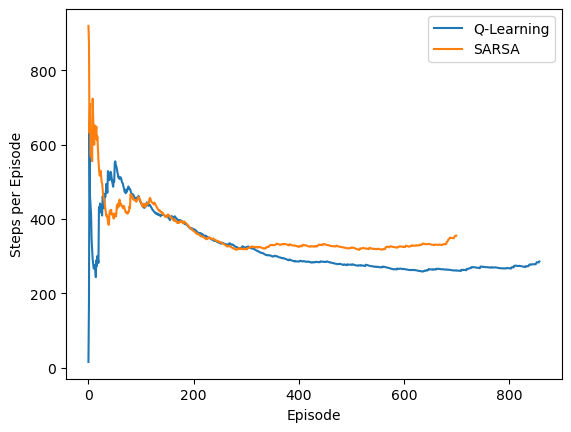

PyObject Text(0.5, 24.0, 'Episode')

In [9]:
PyPlot.plot(agent_Q.steps_per_episode[2:end], label = "Q-Learning")
PyPlot.plot(agent_SARSA.steps_per_episode[2:end], label = "SARSA")
legend()
ylabel("Steps per Episode")
xlabel("Episode")

<i>Score as a function of $\epsilon$ decay:</i>

In [10]:
#this experiment is pretty slow!

SARSA_scores = []
Q_scores = []
SARSA_steps_per_episode = []
Q_steps_per_episode = []
@time for decay in 0.9500:0.0005:0.9995
    scores_SARSA = []
    scores_Q = []
    steps_per_episode_SARSA = []
    steps_per_episode_Q = []
    for j in 1:5
        agent = Agent(env, :SARSA, ϵ_decay = decay);
        run_learning!(agent, 100_000)
        push!(scores_SARSA,agent.score)
        push!(steps_per_episode_SARSA,agent.steps_per_episode[end])
        
        agent = Agent(env, :Qlearning, ϵ_decay = decay);
        run_learning!(agent, 100_000)
        push!(scores_Q,agent.score)
        push!(steps_per_episode_Q,agent.steps_per_episode[end])
    end
    push!(SARSA_scores,sum(scores_SARSA)/length(scores_SARSA))
    push!(SARSA_steps_per_episode,sum(steps_per_episode_SARSA)/length(steps_per_episode_SARSA))
    push!(Q_scores,sum(scores_Q)/length(scores_Q))
    push!(Q_steps_per_episode,sum(steps_per_episode_Q)/length(steps_per_episode_Q))
end


754.749095 seconds (4.29 G allocations: 175.223 GiB, 6.40% gc time, 0.00% compilation time)


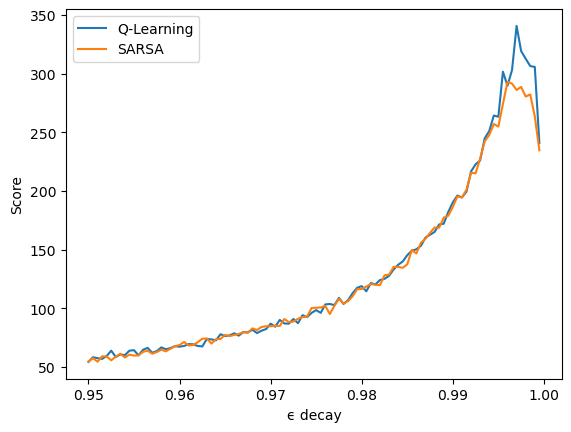

PyObject Text(0.5, 24.0, 'ϵ decay')

In [11]:
PyPlot.plot(collect(0.9500:0.0005:0.9995),Q_scores, label = "Q-Learning")
PyPlot.plot(collect(0.9500:0.0005:0.9995),SARSA_scores, label = "SARSA")
legend()
ylabel("Score")
xlabel("ϵ decay")

<i>Steps per episode as a function of $\epsilon$ decay:</i>

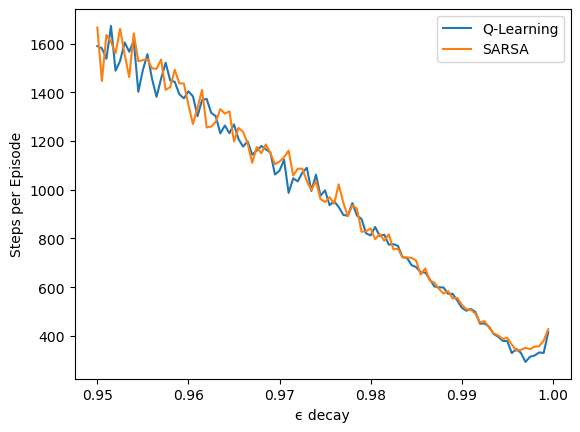

PyObject Text(0.5, 24.0, 'ϵ decay')

In [12]:
PyPlot.plot(collect(0.9500:0.0005:0.9995),Q_steps_per_episode, label = "Q-Learning")
PyPlot.plot(collect(0.9500:0.0005:0.9995),SARSA_steps_per_episode, label = "SARSA")
legend()
ylabel("Steps per Episode")
xlabel("ϵ decay")